# <center> <b> Insurance Cross Sell Prediction

### Mounting the Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setting up PySpark in Google Colab

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [5]:
!tar -xvf spark-3.1.2-bin-hadoop2.7.tgz

spark-3.1.2-bin-hadoop2.7/
spark-3.1.2-bin-hadoop2.7/R/
spark-3.1.2-bin-hadoop2.7/R/lib/
spark-3.1.2-bin-hadoop2.7/R/lib/sparkr.zip
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/worker/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/worker/worker.R
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/worker/daemon.R
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/tests/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/profile/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/profile/shell.R
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/profile/general.R
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/R/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/R/SparkR
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/R/SparkR.rdx
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/R/SparkR.rdb
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/Meta/
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/Meta/features.rds
spark-3.1.2-bin-hadoop2.7/R/lib/SparkR/Meta/pac

### Installing Pyspark

In [6]:
!pip install -q findspark

### Loading environment

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [8]:
import findspark

findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql.functions as F

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
def ignore_warn(*args, **kwagrs):
    pass
warnings.warn = ignore_warn

In [10]:
sns.set_style("whitegrid")
sns.color_palette("bright")
plt.style.use('ggplot')

plt.style.use("fivethirtyeight")

### Reading DataSet

In [11]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('diabetic').getOrCreate()
train = '/content/drive/MyDrive/pre/archive(1)/train.csv'
test = '/content/drive/MyDrive/pre/archive(1)/test.csv'
train = spark.read.csv(train, header = True, inferSchema = True, nullValue="?")
test = spark.read.csv(test, header = True, inferSchema = True, nullValue="?")

train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)



### Lets have a view on the Dataset


In [12]:
import pandas as pd
pd.DataFrame(train.take(5), columns=train.columns).transpose()

,0,1,2,3,4
id,1,2,3,4,5
Gender,Male,Male,Male,Male,Female
Age,44,76,47,21,29
Driving_License,1,1,1,1,1
Region_Code,28,3,28,11,41
Previously_Insured,0,0,0,1,1
Vehicle_Age,> 2 Years,1-2 Year,> 2 Years,< 1 Year,< 1 Year
Vehicle_Damage,Yes,No,Yes,No,No
Annual_Premium,40454,33536,38294,28619,27496
Policy_Sales_Channel,26,26,26,152,152


In [13]:
type(train)

pyspark.sql.dataframe.DataFrame

In [14]:
train.count()

381109

In [15]:
train.dtypes

[('id', 'int'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Driving_License', 'int'),
 ('Region_Code', 'double'),
 ('Previously_Insured', 'int'),
 ('Vehicle_Age', 'string'),
 ('Vehicle_Damage', 'string'),
 ('Annual_Premium', 'double'),
 ('Policy_Sales_Channel', 'double'),
 ('Vintage', 'int'),
 ('Response', 'int')]

# Data Exploration
There are no missing values

In [16]:
# counting null values
train.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in train.columns]).first().asDict()

{'Age': 0,
 'Annual_Premium': 0,
 'Driving_License': 0,
 'Gender': 0,
 'Policy_Sales_Channel': 0,
 'Previously_Insured': 0,
 'Region_Code': 0,
 'Response': 0,
 'Vehicle_Age': 0,
 'Vehicle_Damage': 0,
 'Vintage': 0,
 'id': 0}

# Data imbalance
We can see that the data is imbalanced

In [17]:
train.groupby('Response').count().toPandas()

,Response,count
0,1,46710
1,0,334399


# Conversion Rate
As a real word scenariao there is less conversion Rate

In [18]:
print('Conversion rate:', round(len(train.toPandas()[train.toPandas()['Response'] == 1]) * 100 / len(train.toPandas()), 1), '%')

Conversion rate: 12.3 %


# Correlation
We can see that there is less correlation among column

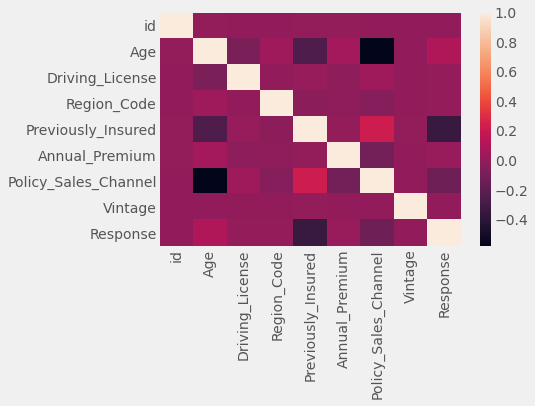

In [19]:
sns.heatmap(train.toPandas().corr())

## lets take a look on Categorical and Numeric Data

Categorical Columns

In [20]:
train.toPandas().select_dtypes(include = object).head()

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


Numerical Columns

In [21]:
train.toPandas().select_dtypes(include = np.number).head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,40454.0,26.0,217,1
1,2,76,1,3.0,0,33536.0,26.0,183,0
2,3,47,1,28.0,0,38294.0,26.0,27,1
3,4,21,1,11.0,1,28619.0,152.0,203,0
4,5,29,1,41.0,1,27496.0,152.0,39,0


Number of Unique Values in Each Column

In [22]:
train.toPandas().nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

# Gender wise Response
Males give Slight More Response that Female

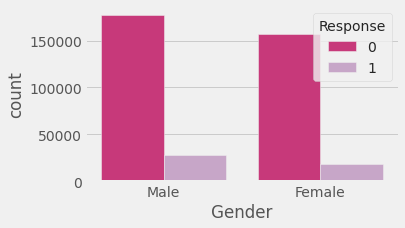

In [23]:
df2 = train.toPandas()
plt.figure(figsize=(5,3))
sns.countplot(df2.Gender,hue=df2.Response,palette='PuRd_r')
plt.show()

# Vehicle Age wise Response
We can see that the cars between 1-2 year has most of the Response

As the Insurance given while purchasing would be ended after 1 yr

But for the cars age greater that 2 they have a less response rate as they might stick with the Previous Insurer or took Insurance of multiple yrs combined

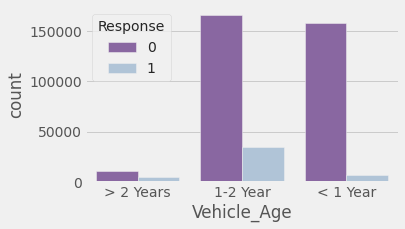

In [24]:
plt.figure(figsize=(5,3))
sns.countplot(df2.Vehicle_Age,hue=df2.Response,palette='BuPu_r')
plt.show()

# Outliers
Annual_Premium have a lot of outlier in the upper range, this can be solved using IQR Method or log (if possible).



* Region_Code & Policy Sales Channel is basically not a numeric data type, they are categorical data that represent by numbers. We need to do feature engineering to transform these features.
* Driving_License & Previously_Insured are categorical data that have been label encoded.
* Age, Annual_Premium, Vintage are numerical-discrete data types, we need to check the distribution of these features.

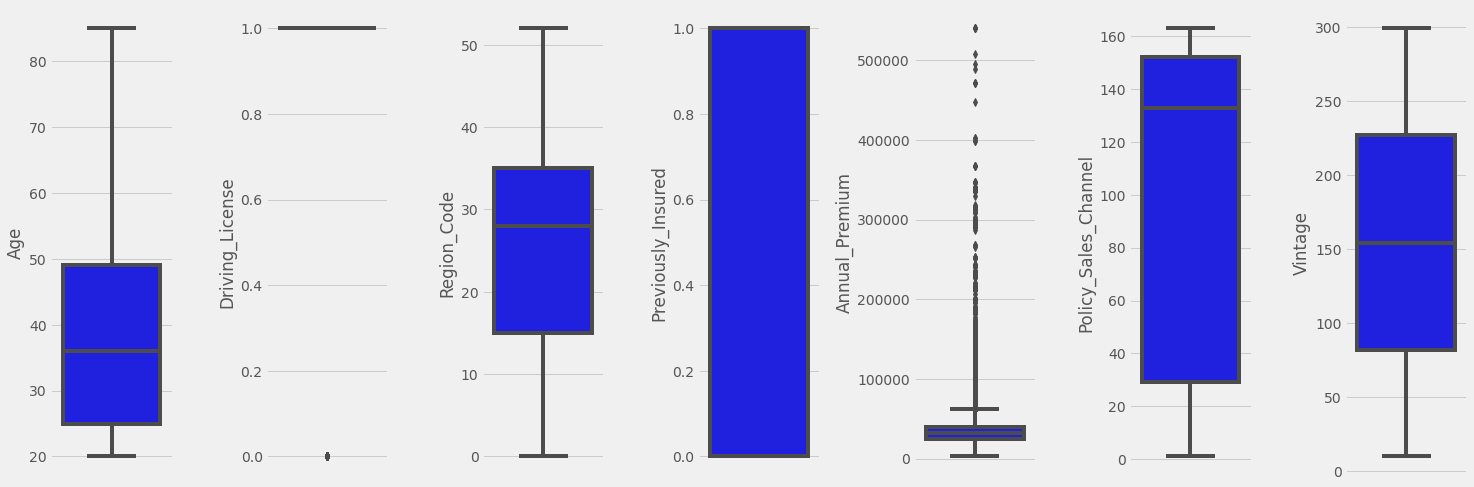

In [25]:
features_num = ['Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage']
plt.figure(figsize = (20.7, 7))
for i in range(0, len(features_num)):
    plt.subplot(1, 7, i + 1)
    sns.boxplot(
        y = df2[features_num[i]],
        color = 'blue'
    )

plt.tight_layout()

Text(0, 0.5, 'Count')

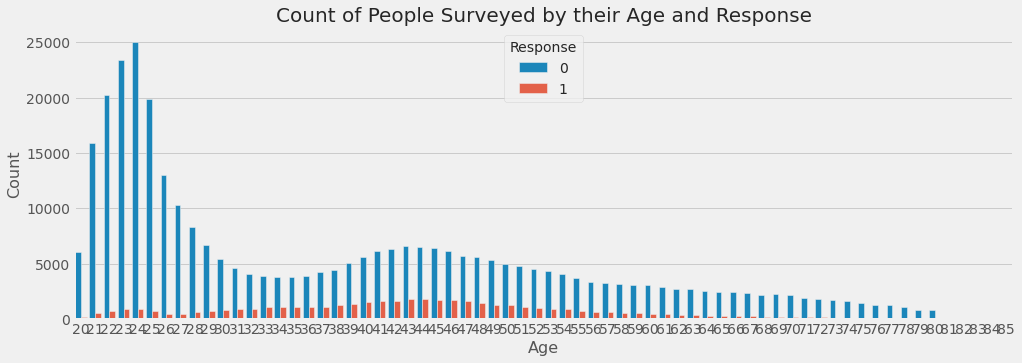

In [26]:
ageCount = train.groupBy(["Age", "Response"]).count().toPandas()
avgPremiumByAge = train.groupBy(["Age", "Response"]).avg("Annual_Premium").withColumnRenamed("avg(Annual_Premium)","Avg_Annual_Premium").toPandas()
maxPremiumByAge = train.groupBy(["Age", "Response"]).max("Annual_Premium").withColumnRenamed("max(Annual_Premium)","Max_Annual_Premium").toPandas()

# fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, sharex = False, figsize = (20, 24))
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (15, 5))

sns.barplot(ageCount["Age"], ageCount["count"], hue = ageCount["Response"], ax = ax1)
ax1.set_title("Count of People Surveyed by their Age and Response", fontsize = 20)
ax1.set_xlabel("Age",fontsize = 16); ax1.set_ylabel("Count",fontsize = 16)


Text(0.5, 1.0, 'Average insurance premium by Age and Response')

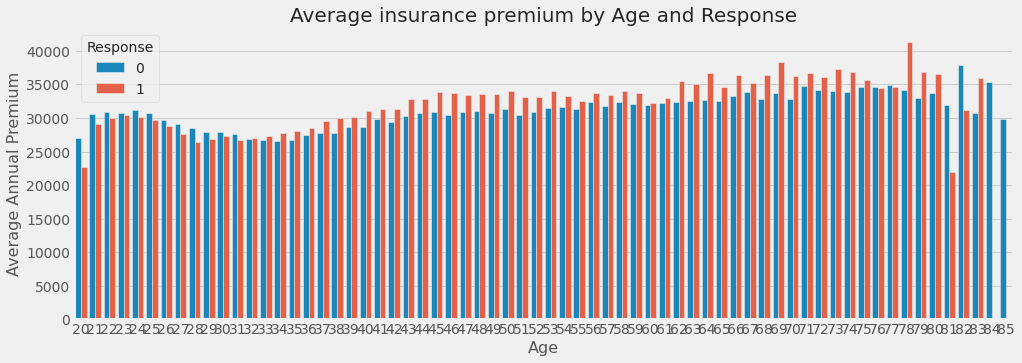

In [27]:
fig, (ax2) = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (15, 5))

sns.barplot(avgPremiumByAge["Age"], avgPremiumByAge["Avg_Annual_Premium"], hue = avgPremiumByAge["Response"],ax = ax2)
ax2.set_xlabel("Age",fontsize = 16); ax2.set_ylabel("Average Annual Premium",fontsize = 16)
ax2.set_title("Average insurance premium by Age and Response", fontsize = 20)


Text(0.5, 1.0, 'Maximum insurance premium by Age and Response')

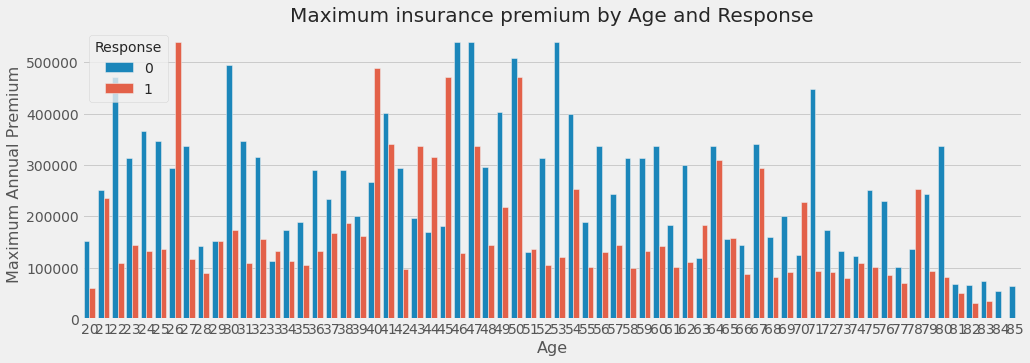

In [28]:
fig, (ax3) = plt.subplots(nrows = 1, ncols = 1, sharex = False, figsize = (15, 5))
sns.barplot(maxPremiumByAge["Age"], maxPremiumByAge["Max_Annual_Premium"],hue = maxPremiumByAge["Response"],ax = ax3)
ax3.set_xlabel("Age",fontsize = 16); ax3.set_ylabel("Maximum Annual Premium",fontsize = 16)
ax3.set_title("Maximum insurance premium by Age and Response", fontsize = 20)

# Vehicle Damage in Past
The People who had Damage their vehicle in past has given a good response

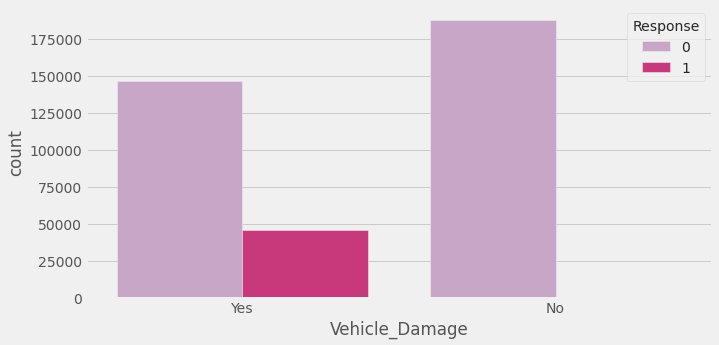

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(df2.Vehicle_Damage,hue=df2.Response,palette='PuRd')
plt.show()

As we can see below People who had history of car damage has already opted with car Insurance

# Data Cleaning

#UpSampling 
The class with "1"

In [30]:
df_a = train.filter(train['Response'] == 0)
df_b = train.filter(train['Response'] == 1)

a_count = df_a.count()
b_count = df_b.count() 
ratio = a_count / b_count

df_b_overampled = df_b.sample(withReplacement=True, fraction=ratio, seed=1)
df = df_a.unionAll(df_b_overampled)

Now the data is Balanced

In [31]:
df.groupby('Response').count().toPandas()

,Response,count
0,1,334887
1,0,334399


Removing NA values

In [32]:
df.toPandas().isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

# Modelling

In [33]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['Gender',	'Vehicle_Age',	'Vehicle_Damage']
stages = []


for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Response', outputCol = 'label')
stages += [label_stringIdx]

In [34]:
numericCols = features_num
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [35]:
stages

[StringIndexer_43e26a914e5e,
 OneHotEncoder_1c79ae2bbf73,
 StringIndexer_44aeae204263,
 OneHotEncoder_cd842e50d0e8,
 StringIndexer_dae134b958fa,
 OneHotEncoder_c35c0fa9ca91,
 StringIndexer_42df62a81b31,
 VectorAssembler_c9342386aeff]

In [36]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
id,2,4,5,6,7
Gender,Male,Male,Female,Female,Male
Age,76,21,29,24,23
Driving_License,1,1,1,1,1
Region_Code,3,11,41,33,11
Previously_Insured,0,1,1,0,0
Vehicle_Age,1-2 Year,< 1 Year,< 1 Year,< 1 Year,< 1 Year
Vehicle_Damage,No,No,No,Yes,Yes
Annual_Premium,33536,28619,27496,2630,23367
Policy_Sales_Channel,26,152,152,160,152


In [37]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)


In [38]:
cols = df.columns
cols

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response',
 'GenderIndex',
 'GenderclassVec',
 'Vehicle_AgeIndex',
 'Vehicle_AgeclassVec',
 'Vehicle_DamageIndex',
 'Vehicle_DamageclassVec',
 'label',
 'features']

In [39]:
selectedCols = ['label', 'features'] + cols
selectedCols = cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Driving_License: integer (nullable = true)
 |-- Region_Code: double (nullable = true)
 |-- Previously_Insured: integer (nullable = true)
 |-- Vehicle_Age: string (nullable = true)
 |-- Vehicle_Damage: string (nullable = true)
 |-- Annual_Premium: double (nullable = true)
 |-- Policy_Sales_Channel: double (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Response: integer (nullable = true)
 |-- GenderIndex: double (nullable = false)
 |-- GenderclassVec: vector (nullable = true)
 |-- Vehicle_AgeIndex: double (nullable = false)
 |-- Vehicle_AgeclassVec: vector (nullable = true)
 |-- Vehicle_DamageIndex: double (nullable = false)
 |-- Vehicle_DamageclassVec: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



#### We now have 'features' & 'label' columns
let's train-test-split usng randomSplit


In [40]:
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 535192
Test Dataset Count: 134094


In [41]:
df.select('features','label').show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,1.0,0.0,0.0,...|  1.0|
|[1.0,0.0,1.0,0.0,...|  1.0|
|[0.0,0.0,1.0,0.0,...|  1.0|
|[0.0,0.0,1.0,1.0,...|  1.0|
|[1.0,0.0,1.0,1.0,...|  1.0|
|[0.0,0.0,1.0,0.0,...|  1.0|
|[0.0,0.0,1.0,0.0,...|  1.0|
|[0.0,0.0,1.0,0.0,...|  1.0|
|[0.0,1.0,0.0,0.0,...|  1.0|
|[1.0,1.0,0.0,1.0,...|  1.0|
+--------------------+-----+
only showing top 10 rows



# Logistic Regression

In [42]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8, labelCol="label", 
                        featuresCol="features")
lrModel = lr.fit(train)

preds_lr = lrModel.transform(test)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(preds_lr)
print("Accuracy = %g" % accuracy)

Accuracy = 0.784584


In [43]:
pd.DataFrame(preds_lr.take(5), columns=preds_lr.columns).transpose()

,0,1,2,3,4
id,2,13,17,18,23
Gender,Male,Female,Female,Female,Male
Age,76,41,25,25,23
Driving_License,1,1,1,1,1
Region_Code,3,15,45,35,50
Previously_Insured,0,1,0,1,1
Vehicle_Age,1-2 Year,1-2 Year,< 1 Year,< 1 Year,< 1 Year
Vehicle_Damage,No,No,Yes,No,No
Annual_Premium,33536,31409,26218,46622,45283
Policy_Sales_Channel,26,14,160,152,152


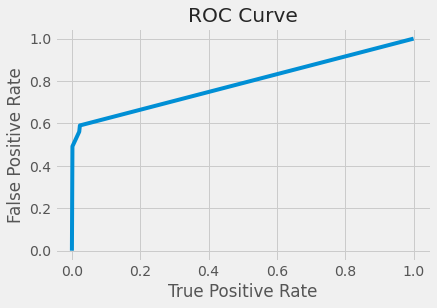

Training set areaUnderROC: 0.7886736801681599


In [44]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

# Decision Tree

In [45]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

Accuracy = 0.785919


In [46]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7304788501375141


# Random Forest

In [47]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=100, maxDepth=6, labelCol="label", seed=42,
                           featureSubsetStrategy='onethird')
rfmodel = rf.fit(train)

predictions = rfmodel.transform(test)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

Accuracy = 0.793951


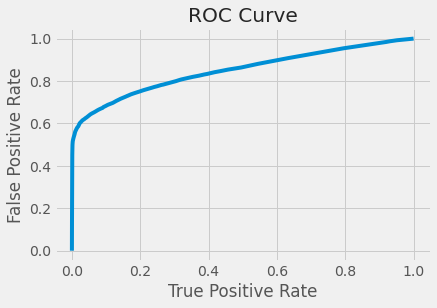

Training set areaUnderROC: 0.8483965521851073


In [48]:
trainingSummary = rfmodel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [49]:
rfmodel.featureImportances

SparseVector(11, {0: 0.0007, 1: 0.015, 2: 0.0337, 3: 0.5129, 4: 0.0935, 5: 0.0004, 6: 0.0016, 7: 0.3078, 8: 0.0007, 9: 0.0336, 10: 0.0001})

# Gradient Boosting

In [50]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(maxIter=100, labelCol="label",featuresCol="features")
gbtModel = gbt.fit(train)

preds_gb = gbtModel.transform(test)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(preds_gb)
print("Accuracy = %g" % accuracy)

Accuracy = 0.802131


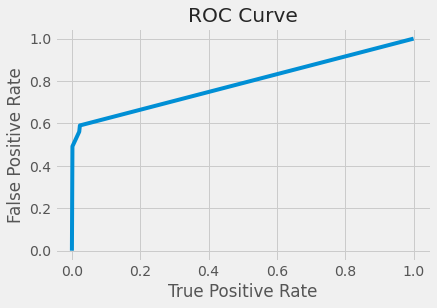

Test Area Under ROC: 0.859378109544203


In [51]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(preds_gb, {evaluator.metricName: "areaUnderROC"})))

# As GBT has the highest Accuracy and AUC 
We will be running Crossvalidation and Grid Search for it 

In [52]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about several minutes!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)

accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

print('Test Area Under ROC', evaluator.evaluate(predictions))

Accuracy = 0.856463
Test Area Under ROC 0.8564676091214669


# Conclusion
As we can see that ROC Score for Boosting Algorithm is slight higher than the other As it converts weak learner to strong learners.

Therefore we can Move ahead with the Gradient Boosting with the Best Params which we have found using Grid Search and validated using CrossValidation.


## Key Insights


*   We can target the customers who has car 1-2 yrs old
*   We have seen very strong response from people who had previously damaged the car.
*   Even if the person show interest and deosn't buys it, we can still take the track again before the Vehicle Insurance expires




